# Improve Cache Efficiency by Blocking

:label:`ch_block_matmul_cpu`


In :numref:`ch_matmul_cpu` we saw that properly reordering the memory access pattern with parallelization could dramatically improve the performance for small-scale matrix multiplication. However, for large matrices, we need to carefully consider the cache hierarchy discussed in :numref:`ch_cpu_arch`.

In [1]:
%matplotlib inline
import tvm
import numpy as np
import d2ltvm

target = 'llvm -mcpu=skylake-avx512'

Before we started, let's rerun the benchmark for NumPy as our baseline.

In [2]:
sizes = 2**np.arange(5, 12, 1)
np_times = [d2ltvm.bench_workload(d2ltvm.np_matmul_timer(n)) for n in sizes]
np_gflops = 2 * sizes **3 / 1e9 / np.array(np_times)

## Blocked Matrix Multiplication

One commonly used strategy is tiling matrices into small blocks that can be fitted into the cache.
The math behind it is that a block of $C$, e.g. `C[x:x+tx, y:y+ty]` by the NumPy notation, can be computed by the according rows of $A$ and columns of $B$. That is

``C[x:x+tx, y:y+ty] = np.dot(A[x:x+tx,:], B[:,y:y+ty])``

We can further decompose this matrix multiplication into multiple small ones

``C[x:x+tx, y:y+ty] = sum(np.dot(A[x:x+tx,k:k+tk], B[k:k+tk,y:y+ty]) for k in range(0,n,tk))``

This computation is also illustrated in :numref:`fig_matmul_block`.

![Blocked tiling for matrix multiplication.](../img/matmul_block.svg)

:label:`fig_matmul_block`


In each submatrix computation, we need to write a `(tx, ty)` shape matrix, and reach two matrices with shapes `(tx, tk)` and `(tk, ty)`. We can compute such a computation in a single CPU core. If we properly choose the tiling sizes `tx`, `ty` and `tk` to fit into the L1 cache, which is 32KB for our CPU (refer to :numref:`ch_cpu_arch`). The reduced cache miss then should improve the performance.

Let's implement this idea. In the following codes, we choose `tx=ty=32` so that the submatrix to write has a size of `32*32*4=4KB`. The total size of the two submatrices to read is `2*32*4*4=1KB`. All of them can fit into our L1 cache easily. The tiling is implemented by the `split` method.

After tiling, we merge the outer width and height axes into a single one, so we can parallelize it. It means we will compute each block in parallel. Within a block, we reorder the axes, and then hint the compiler to use SIMD for the innermost axis, which is the inner axis split from the height axis, and unroll the second innermost axis, namely the inner reduction axis.

In [3]:
tx, ty, tk = 32, 32, 4  # tile sizes

def block(n):
    A, B, C = d2ltvm.matmul(n, n, n)
    s = tvm.create_schedule(C.op)
    # Tile by blocks, and then parallelize the computation of each block
    xo, yo, xi, yi = s[C].tile(*C.op.axis, tx, ty)
    xy = s[C].fuse(xo, yo)
    s[C].parallel(xy)
    # Optimize the computation of each block
    ko, ki = s[C].split(s[C].op.reduce_axis[0], factor=tk)
    s[C].reorder(ko, xi, ki, yi)
    s[C].vectorize(yi)
    s[C].unroll(ki)
    return s, (A, B, C)

s, (A, B, C) = block(64)
print(tvm.lower(s, [A, B, C], simple_mode=True))

produce C {
  parallel (x.outer.y.outer.fused, 0, 4) {
    for (x.inner.init, 0, 32) {
      C[ramp((((floordiv(x.outer.y.outer.fused, 2)*2048) + (x.inner.init*64)) + (floormod(x.outer.y.outer.fused, 2)*32)), 1, 32)] = x32(0f)
    }
    for (k.outer, 0, 16) {
      for (x.inner, 0, 32) {
        C[ramp((((floordiv(x.outer.y.outer.fused, 2)*2048) + (x.inner*64)) + (floormod(x.outer.y.outer.fused, 2)*32)), 1, 32)] = (C[ramp((((floordiv(x.outer.y.outer.fused, 2)*2048) + (x.inner*64)) + (floormod(x.outer.y.outer.fused, 2)*32)), 1, 32)] + (x32(A[(((floordiv(x.outer.y.outer.fused, 2)*2048) + (x.inner*64)) + (k.outer*4))])*B[ramp(((k.outer*256) + (floormod(x.outer.y.outer.fused, 2)*32)), 1, 32)]))
        C[ramp((((floordiv(x.outer.y.outer.fused, 2)*2048) + (x.inner*64)) + (floormod(x.outer.y.outer.fused, 2)*32)), 1, 32)] = (C[ramp((((floordiv(x.outer.y.outer.fused, 2)*2048) + (x.inner*64)) + (floormod(x.outer.y.outer.fused, 2)*32)), 1, 32)] + (x32(A[((((floordiv(x.outer.y.outer.fused, 2)*204

From the generated C-like codes, we can see that `parallel` is placed on the `x.outer`, i.e. `xo`, axis. The vectorization translated the axis `yi`, whose length is 32, into `ramp` with a stride 1 and width 32. Besides, the axis `ki` is also replaced by 4 length sequential sequence to reduce the cost of the for-loop.

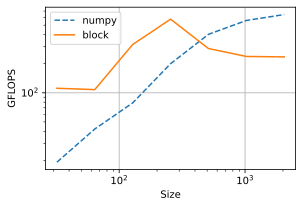

In [4]:
blocked_gflops = d2ltvm.bench_matmul_tvm(block, sizes, target)
d2ltvm.plot_gflops(sizes, [np_gflops, blocked_gflops], ['numpy', 'block'])

The benchmark results show that our program is as good as NumPy for small matrices, but still doesn't do well for large ones. One major reason is because both read and write of these submatrices are not sequential.

## Write Cache

The non-sequential write issue is larger than the non-sequential read. This is because we read once of each submatrix of `A` and `B`, but need to write by `n` times for the submatrix of `C`. In the following codes, we first write the results into a local cache for each submatrix computation, and then write them back to `C`. It can be done by the `cache_write` method. We specify the cache is used for each block by placing it within the `yo` axis by `compute_at`. The rest optimization is same as before, but note that we need to use `s[Cached]` instead of `s[C]` to optimize the submatrix computation.

In [5]:
def cached_block(n):
    A, B, C = d2ltvm.matmul(n, n, n)
    s = tvm.create_schedule(C.op)
    # Create a write cache for C
    CachedC = s.cache_write(C, 'local')
    # Same as before, first tile by blocks, and then parallelize the
    # computation of each block
    xo, yo, xi, yi = s[C].tile(*C.op.axis, tx, ty)
    xy = s[C].fuse(xo, yo)
    s[C].parallel(xy)
    # Use the write cache for the output of the xy axis, namely a block.
    s[CachedC].compute_at(s[C], xy)
    # Same as before to optimze the computation of a block .
    xc, yc = s[CachedC].op.axis
    ko, ki = s[CachedC].split(CachedC.op.reduce_axis[0], factor=tk)
    s[CachedC].reorder(ko, xc, ki, yc)
    s[CachedC].unroll(ki)
    s[CachedC].vectorize(yc)
    return s, (A, B, C)

s, (A, B, C) = cached_block(512)
print(tvm.lower(s, [A, B, C], simple_mode=True))

produce C {
  parallel (x.outer.y.outer.fused, 0, 256) {
    // attr [C.local] storage_scope = "local"
    allocate C.local[float32 * 1024]
    produce C.local {
      for (x.c.init, 0, 32) {
        C.local[ramp((x.c.init*32), 1, 32)] = x32(0f)
      }
      for (k.outer, 0, 128) {
        for (x.c, 0, 32) {
          C.local[ramp((x.c*32), 1, 32)] = (C.local[ramp((x.c*32), 1, 32)] + (x32(A[(((floordiv(x.outer.y.outer.fused, 16)*16384) + (x.c*512)) + (k.outer*4))])*B[ramp(((k.outer*2048) + (floormod(x.outer.y.outer.fused, 16)*32)), 1, 32)]))
          C.local[ramp((x.c*32), 1, 32)] = (C.local[ramp((x.c*32), 1, 32)] + (x32(A[((((floordiv(x.outer.y.outer.fused, 16)*16384) + (x.c*512)) + (k.outer*4)) + 1)])*B[ramp((((k.outer*2048) + (floormod(x.outer.y.outer.fused, 16)*32)) + 512), 1, 32)]))
          C.local[ramp((x.c*32), 1, 32)] = (C.local[ramp((x.c*32), 1, 32)] + (x32(A[((((floordiv(x.outer.y.outer.fused, 16)*16384) + (x.c*512)) + (k.outer*4)) + 2)])*B[ramp((((k.outer*2048) + (floorm

Note from the generated codes that we initialize `C.local` within the `yo` axis, and the size of `C.local` is `tx * ty = 1024`.

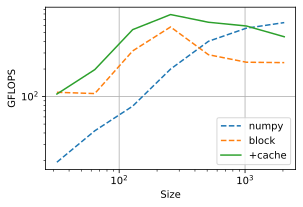

In [6]:
cached_gflops = d2ltvm.bench_matmul_tvm(cached_block, sizes, target)
d2ltvm.plot_gflops(sizes, [np_gflops, blocked_gflops, cached_gflops],
            ['numpy', 'block', '+cache'])

We can see the the write cache improves the performance for large matrices.

## Summary

1. Blocked tiling improves cache efficiency for matrix multiplication.
1. Frequent read and write data can be placed in cache explicitly to reduce cache misses

## Exercises

1. Try different hyperparameters for `tx`, `ty` and `tx`.
1. Try different axis orders.
1. Benchmark on larger matrices, observe if there is still performance gap between NumPy. If so, explain it.
1. Evaluate the correctness of the computed results